In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score,train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost
import seaborn as sns
from sklearn.preprocessing import LabelEncoder





%matplotlib inline

c:\users\python\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Груим и смотрим данные

In [2]:
train = pd.read_csv('rosbank_train.csv')
test = pd.read_csv('rosbank_test.csv')
mcc = pd.read_excel('mcc_codes.xlsx', names = ['MCC','MCC_Name','MCC_Group'])


In [28]:
#Уникальные категории транзакций
train.trx_category.unique()

array(['POS', 'DEPOSIT', 'C2C_OUT', 'WD_ATM_ROS', 'BACK_TRX',
       'WD_ATM_PARTNER', 'WD_ATM_OTHER', 'C2C_IN', 'CAT', 'CASH_ADV'],
      dtype=object)

In [4]:
## Выделяем зависимую переменную
y_train = train[['cl_id','target_flag']].copy()
train.drop (columns= ['target_flag','target_sum'],axis=1, inplace= True)
y_train= y_train.groupby(by= 'cl_id').min().reset_index()
y_train.drop(columns=['cl_id'], inplace= True)
y_train.head()

,target_flag
0,0
1,0
2,1
3,0
4,0


In [5]:
# Для предобработки объеденяем трейн и тест
train['IsTrain'] = 1
test['IsTrain'] = 0
train_test = pd.concat( [train, test], axis = 0 )

In [6]:
# One hot encoding для категорий транзаций + знак направления операции
def trx_categories(df_in):
    categories =   {'POS': 0, \
                    'DEPOSIT': 1, \
                    'WD_ATM_ROS': 2, \
                    'WD_ATM_PARTNER': 3, \
                    'C2C_IN': 4, \
                    'WD_ATM_OTHER': 5, \
                    'C2C_OUT': 6, \
                    'BACK_TRX': 7, \
                    'CAT': 8, \
                    'CASH_ADV': 9}
    trx_sign = {0 : -1, 
                1 : 1,
                2 : -1,
                3 : -1,
                4 : 1,
                5 : -1,
                6 : -1,
                7 : 1,
                8 : -1,
                9 : -1}

    df_in['trx_category'].replace(categories, inplace = True)
    df_in['amount'] = df_in[['trx_category', 'amount']].apply(lambda d: d[1] * trx_sign[d[0]], axis = 1)
    

In [7]:
# Пременяем функцию
trx_categories(train_test)

In [8]:
train_test.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,IsTrain
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,-5023.0,0,1
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,1,1
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,-767.0,0,1
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,-2031.0,0,1
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,-36562.0,6,1


In [10]:
# Создаем аналитику по MCC кодам
def mcc_cat(m):
    beauty = [5698, 5912, 7230, 7297, 7298, 7997, 8011, 8021, 8031, 8041, 8042, 8043, 8044, 8049, 8050, 8062, 8071, 8099]
    home = [5039, 5200, 5211, 5231, 5251, 5712, 5713, 5714, 5718, 5719, 5722, 5932, 5950]
    children = [5611, 5641, 5651, 5661, 5943, 5945, 5970, 7832, 7911, 7922, 7929, 7933, 7941, 7991, 7996, 7998, 7999]
    cafe = [5462, 5499, 5812, 5813, 5814]
    no_cash = [4812, 4814, 4829, 4900, 5933, 5960, 6010, 6011, 6012, 6050, 6051, 6211, 6300, 6529, 6530, 6532, 6533, 6534, 6536, 6537, 6538, 6540, 7276, 7800, 7801, 7802, 7994, 7995, 9222, 9311]
    
    if m in beauty:
        return 1
    if m in home:
        return 2
    if m in children:
        return 3
    if m in cafe:
        return 4
    if m in no_cash:
        return 5
    return 0

In [11]:
# Функция для маркировки "бонусных" транзацций
def is_bonus(d):
    mcc_cat = d[0]
    trx_cat = d[1]
    if trx_cat != 0:
        return 0
    if mcc_cat == 5:
        return 0
    else:
        return 1

In [12]:
def mccs(df_in):
    df_in['MCC_cat'] = df_in['MCC'].apply(mcc_cat)
    df_in['is_bonus'] = df_in[['MCC_cat', 'trx_category']].apply(is_bonus, axis = 1).map(int)


In [51]:
#Создаем фичи
mccs(train_test_mcc)

train_test_mcc.head()

,cl_id,MCC,channel_type,amount,trx_category,IsTrain,MCC_Group,DayDiff,DateGroup10,DateGroup2,CUR,count,MCC_cat,is_bonus
0,0,5200,type6,-5023.0,0,1,Розничные магазины,53.0,2_GR10,1_GR2,RUB,1,2,1
1,0,6011,type6,20000.0,1,1,Поставщик услуг,53.0,1_GR10,1_GR2,RUB,1,5,0
2,0,5921,type6,-767.0,0,1,Различные магазины,53.0,10_GR10,2_GR2,RUB,1,0,1
3,0,5411,type6,-2031.0,0,1,Розничные магазины,53.0,2_GR10,1_GR2,RUB,1,0,1
4,0,6012,type6,-36562.0,6,1,Поставщик услуг,53.0,3_GR10,1_GR2,RUB,1,5,0


In [37]:
train_test_mcc = train_test.merge( mcc, how = 'left', left_on = 'MCC', right_on = 'MCC' )

In [38]:
# Парсинг времени, генерация вечей
train_test_mcc['Year'] = train_test_mcc.TRDATETIME.str[5:7]
train_test_mcc['Month'] = train_test_mcc.TRDATETIME.str[2:5]
train_test_mcc['Date'] = train_test_mcc.TRDATETIME.str[0:2]
train_test_mcc['Hour'] = train_test_mcc.TRDATETIME.str[8:10]
# Replace month with ints
train_test_mcc.Month = train_test_mcc.Month.replace(to_replace=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                                                'JUL','AUG','SEP','OCT','NOV','DEC' ], 
                                    value=[1,2,3,4,5,6,7,8,9,10,11,12])
# Convert to ints (add 2000 to yr)
train_test_mcc.Year = train_test_mcc.Year.astype(int, copy= True)
train_test_mcc.Date = train_test_mcc.Date.astype(int, copy= True)
train_test_mcc.Hour = train_test_mcc.Hour.astype(int, copy= True)
train_test_mcc.Year = train_test_mcc.Year + 2000
# Add function to convert to DateTime and apply it
train_test_mcc['DateTimeFormated'] = train_test_mcc['Year'].astype(str)+'-'+train_test_mcc['Month'].astype(str)
train_test_mcc['DateTimeFormated']= pd.to_datetime(train_test_mcc['DateTimeFormated']+ '-'+train_test_mcc['Date'].astype(str)+ ' '+train_test_mcc['Hour'].astype(str)+ ':00:00')


In [39]:
train_test_mcc.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,IsTrain,MCC_Name,MCC_Group,Year,Month,Date,Hour,DateTimeFormated
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,-5023.0,0,1,Товары для дома,Розничные магазины,2017,10,21,0,2017-10-21 00:00:00
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,1,1,Финансовые учреждения – снятие наличности авто...,Поставщик услуг,2017,10,12,12,2017-10-12 12:00:00
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,-767.0,0,1,Магазины с продажей спиртных напитков навынос,Различные магазины,2017,12,5,0,2017-12-05 00:00:00
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,-2031.0,0,1,"Бакалейные магазины, супермаркеты",Розничные магазины,2017,10,21,0,2017-10-21 00:00:00
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,-36562.0,6,1,Финансовые учреждения – торговля и услуги,Поставщик услуг,2017,10,24,13,2017-10-24 13:00:00


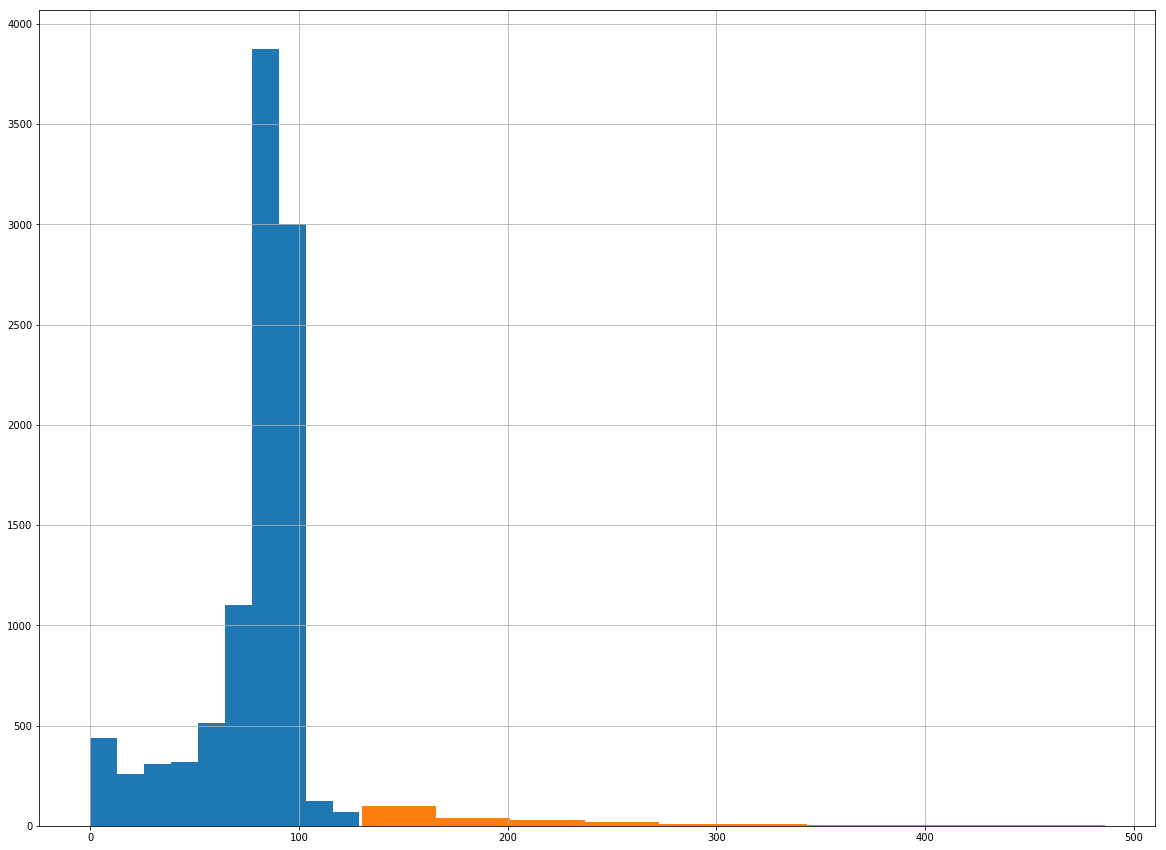

In [40]:
# Фичи первой и последней транзакции клиента
rnm_cols = dict(max='MaxDate', min='MinDate')

x = train_test_mcc[['DateTimeFormated','cl_id']].groupby(by = 'cl_id').agg(rnm_cols.keys()).rename(columns=rnm_cols).reset_index()
x.columns = x.columns.droplevel(1)
x.columns = ['cl_id', 'MaxDate','MinDate']

##x.info()
x['DayDiff'] = (x.MaxDate- x.MinDate).astype('timedelta64[D]')
x.DayDiff[x.DayDiff  < 130].hist( figsize=(20,15))
x.DayDiff[x.DayDiff  >= 130].hist()

In [18]:

x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10217 entries, 0 to 10216
Data columns (total 4 columns):
cl_id      10217 non-null int64
MaxDate    10217 non-null datetime64[ns]
MinDate    10217 non-null datetime64[ns]
DayDiff    10217 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 319.4 KB


In [41]:
# Фичи по временным интервалам совершения сделок каждым клиентом
x['delta_10'] = (x.DayDiff/10).astype(int)
x['delta_2'] = (x.DayDiff/2).astype(int)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10217 entries, 0 to 10216
Data columns (total 6 columns):
cl_id       10217 non-null int64
MaxDate     10217 non-null datetime64[ns]
MinDate     10217 non-null datetime64[ns]
DayDiff     10217 non-null float64
delta_10    10217 non-null int32
delta_2     10217 non-null int32
dtypes: datetime64[ns](2), float64(1), int32(2), int64(1)
memory usage: 399.2 KB


#### получение набора с минимальной и максимальной датой а также интервалаами, для каждой сделки

In [42]:
train_test_mcc = train_test_mcc.merge (x, how = 'left', left_on = 'cl_id', right_on = 'cl_id')

In [43]:
train_test.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'IsTrain'],
      dtype='object')

 ### Создаем фичи - временной ряд количества транзакций клиента по интервалам 

In [44]:
## 10 интервалов
def DateGroup10 (row):
    if row.DateTimeFormated <= row.MinDate+pd.to_timedelta(row.delta_10, unit='D'):
        return '1_GR10'
    if (row.DateTimeFormated <= row.MinDate+2*pd.to_timedelta(row.delta_10, unit='D')) & (row.DateTimeFormated > row.MinDate+ pd.to_timedelta(row.delta_10, unit='D')):
        return '2_GR10'
    if (row.DateTimeFormated <= row.MinDate+3*pd.to_timedelta(row.delta_10, unit='D')) & (row.DateTimeFormated > row.MinDate+ 2*pd.to_timedelta(row.delta_10, unit='D')):
        return '3_GR10'
    if (row.DateTimeFormated <= row.MinDate+4*pd.to_timedelta(row.delta_10, unit='D')) & (row.DateTimeFormated > row.MinDate+ 3*pd.to_timedelta(row.delta_10, unit='D')):
        return '4_GR10'
    if (row.DateTimeFormated <= row.MinDate+5*pd.to_timedelta(row.delta_10, unit='D')) & (row.DateTimeFormated > row.MinDate+ 4*pd.to_timedelta(row.delta_10, unit='D')):
        return '5_GR10'
    if (row.DateTimeFormated <= row.MinDate+6*pd.to_timedelta(row.delta_10, unit='D')) & (row.DateTimeFormated > row.MinDate+ 5*pd.to_timedelta(row.delta_10, unit='D')):
        return '6_GR10'
    if (row.DateTimeFormated <= row.MinDate+7*pd.to_timedelta(row.delta_10, unit='D')) & (row.DateTimeFormated > row.MinDate+ 6*pd.to_timedelta(row.delta_10, unit='D')):
        return '7_GR10'
    if (row.DateTimeFormated <= row.MinDate+8*pd.to_timedelta(row.delta_10, unit='D')) & (row.DateTimeFormated > row.MinDate+ 7*pd.to_timedelta(row.delta_10, unit='D')):
        return '8_GR10'
    if (row.DateTimeFormated <= row.MinDate+9*pd.to_timedelta(row.delta_10, unit='D')) & (row.DateTimeFormated > row.MinDate+ 8*pd.to_timedelta(row.delta_10, unit='D')):
        return '9_GR10'
    if (row.DateTimeFormated <= row.MaxDate) & (row.DateTimeFormated > row.MinDate+ 9*pd.to_timedelta(row.delta_10, unit='D')):
        return '10_GR10'


In [23]:
# 2 инвервала
def DateGroup2 (row):
    if row.DateTimeFormated <= row.MinDate+pd.to_timedelta(row.delta_2, unit='D'):
        return '1_GR2'
    else:
        return '2_GR2'
    

In [45]:
#Маркируем валюту
def currency (row):
    if row['currency'] == 810:
        return 'RUB'
    else:
        return 'Other'

# Получаем фичи и удаляем лишние столбцы

In [46]:
train_test_mcc['DateGroup10']= train_test_mcc.apply(DateGroup10, axis = 1)
train_test_mcc['DateGroup2']= train_test_mcc.apply(DateGroup2, axis = 1)
train_test_mcc['CUR']= train_test_mcc.apply(currency, axis = 1)
# Заменим пустые значения на новый канал
train_test_mcc.channel_type.fillna(value = 'type6',inplace = True)

train_test_mcc.drop (columns = ['TRDATETIME','MCC_Name','Year','Month','Date','Hour', 'DateTimeFormated','MaxDate',
                                'MinDate','delta_10','delta_2','currency','PERIOD'],inplace = True)

In [47]:
train_test_mcc.head()

,cl_id,MCC,channel_type,amount,trx_category,IsTrain,MCC_Group,DayDiff,DateGroup10,DateGroup2,CUR
0,0,5200,type6,-5023.0,0,1,Розничные магазины,53.0,2_GR10,1_GR2,RUB
1,0,6011,type6,20000.0,1,1,Поставщик услуг,53.0,1_GR10,1_GR2,RUB
2,0,5921,type6,-767.0,0,1,Различные магазины,53.0,10_GR10,2_GR2,RUB
3,0,5411,type6,-2031.0,0,1,Розничные магазины,53.0,2_GR10,1_GR2,RUB
4,0,6012,type6,-36562.0,6,1,Поставщик услуг,53.0,3_GR10,1_GR2,RUB


In [48]:
client_channel = train_test_mcc[['cl_id','channel_type']].groupby('cl_id').max().reset_index()

# Разворачиваем таблицу получая фичи и частоту их встречания у каждого клиента

In [52]:
# создаем фиктивный столбец для подсчета count
train_test_mcc['count'] = 1
# Создаем много "маленьких" пивот таблиц и объеденяем их. Не нашел иного стособа получить такой набор
piv1 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'MCC_Group'], values = 'count', aggfunc = 'sum',fill_value=0 ).reset_index()
piv3 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'trx_category'], values = 'count', aggfunc = 'sum',fill_value=0 ).reset_index()
piv4 = train_test_mcc[['cl_id','DayDiff']].groupby(by = ['cl_id']).max().reset_index()
piv5 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'DateGroup10'], values = 'count', aggfunc = 'sum' ,fill_value=0).reset_index()
piv6 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'DateGroup2'], values = 'count', aggfunc = 'sum',fill_value=0 ).reset_index()
piv7 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'CUR'], values = 'count', aggfunc = 'sum',fill_value=0 ).reset_index()
piv8 = train_test_mcc[['cl_id','IsTrain']].groupby(by = ['cl_id']).min().reset_index()
piv9 = pd.get_dummies (train_test_mcc[['cl_id','channel_type']])
piv9 = piv9.groupby(by = 'cl_id').max().reset_index()
piv10 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'MCC'], values = 'count', aggfunc = 'sum',fill_value=0).reset_index()
piv11 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'MCC_cat'], values = 'count', aggfunc = 'sum',fill_value=0).reset_index()
piv11.columns  = ['mcc_gr_' + str(s) for s in piv11.columns]
piv12 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'MCC_cat'], values = 'amount', aggfunc = 'sum',fill_value=0).reset_index()
piv12.columns  = ['mcc_cat__amount_' + str(s) for s in piv12.columns]
piv13 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'is_bonus'], values = 'count', aggfunc = 'sum',fill_value=0).reset_index()
piv13.columns  = ['is_bonus_cou_' + str(s) for s in piv13.columns]
piv14 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'is_bonus'], values = 'amount', aggfunc = 'sum',fill_value=0).reset_index()
piv14.columns  = ['is_bonus_amount_' + str(s) for s in piv14.columns]

piv15 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'DateGroup2'], values = 'amount', aggfunc = 'sum',fill_value=0 ).reset_index()
piv15.columns  = ['date_gr_2_amount_' + str(s) for s in piv15.columns]
piv16 = pd.pivot_table( train_test_mcc, index = ['cl_id'], columns = [ 'DateGroup10'], values = 'amount', aggfunc = 'sum',fill_value=0 ).reset_index()
piv16.columns  = ['date_gr_10_amount_' + str(s) for s in piv16.columns]

# Объеденяем набор в целую таблицу
result = pd.concat([piv1,piv3,piv4,piv5,piv6,piv7,piv8,piv9,piv10], axis=1)

# Удаляем id клиента, так как колонка не будет принимать участия в обучении
test_cl_id = result[result['IsTrain'] == 0].cl_id
test_cl_id = pd.DataFrame(test_cl_id.iloc[:,0])
test_cl_id.rename(columns={'cl_id':'_ID_'}, inplace=True)


In [53]:
piv11.columns  = ['mcc_gr_' + str(s) for s in piv11.columns]


In [54]:
test_cl_id.head()

,_ID_
2,2
3,3
4,4
6,6
7,7


In [55]:
test_cl_id.head()

,_ID_
2,2
3,3
4,4
6,6
7,7


In [56]:
train_test_mcc.to_csv( 'train_test_mcc.csv' ) ### apply очень медленный. поэтому сохранимся)
##train_test_mcc = pd.read_csv ('train_test_mcc.csv')


## Делим снова модель на глобайльный тест и трейн


In [57]:
general_train = result[result['IsTrain']==1].reset_index(drop= True)
general_test =  result[result['IsTrain']==0].reset_index(drop= True)
general_train.drop(columns=['IsTrain'], inplace=True)
general_test.drop(columns=['IsTrain'], inplace=True)

In [58]:
general_train.shape

(5000, 445)

In [59]:
general_test.shape

(5217, 445)

# Масштабируем данные

In [60]:
# Создаем функцию для масштабирования

def Scal (train_data, test_data):
    scaler = StandardScaler()
    sc = scaler.fit(train_data) ### обучаемся на трейне, потом применяем на тест
    ds1 = pd.DataFrame(sc.transform(train_data), index=train_data.index, columns=train_data.columns)
    ds2 = pd.DataFrame(sc.transform(test_data), index=test_data.index, columns=test_data.columns)
    return ds1, ds2

In [61]:
train_scaled , test_scaled = Scal(general_train,general_test)
train_scaled.head()

,cl_id,"Авиалинии, авиакомпании",Автомобили и транспортные средства,Аренда автомобилей,Бизнес услуги,Государственные услуги,Другое,Коммунальные и кабельные услуги,Контрактные услуги,Личные услуги,...,8699,8911,8931,8999,9211,9222,9311,9399,9402,9405
0,-1.717403,-0.223596,-0.629425,-0.031764,-0.299310,-0.183813,-0.014144,-0.491175,-0.101419,-0.380949,...,-0.030014,-0.020004,-0.026736,-0.323012,-0.044217,-0.055262,-0.101852,-0.185293,-0.053519,-0.028296
1,-1.717067,-0.223596,-0.629425,-0.031764,-0.003608,0.564002,-0.014144,-0.491175,-0.101419,-0.380949,...,-0.030014,-0.020004,-0.026736,-0.323012,-0.044217,-0.055262,2.841836,-0.185293,-0.053519,-0.028296
2,-1.715723,-0.223596,-0.629425,-0.031764,-0.299310,0.564002,-0.014144,1.099211,-0.101419,0.714048,...,-0.030014,-0.020004,-0.026736,-0.323012,-0.044217,1.305878,-0.101852,-0.185293,-0.053519,-0.028296
3,-1.714380,-0.223596,-0.629425,-0.031764,-0.299310,-0.183813,-0.014144,-0.491175,-0.101419,-0.380949,...,-0.030014,-0.020004,-0.026736,-0.323012,-0.044217,-0.055262,-0.101852,-0.185293,-0.053519,-0.028296
4,-1.714044,-0.223596,3.687617,-0.031764,-0.003608,-0.183813,-0.014144,-0.173098,-0.101419,-0.380949,...,-0.030014,-0.020004,-0.026736,0.298404,-0.044217,-0.055262,-0.101852,-0.185293,-0.053519,-0.028296


In [90]:
### Функция для кросс валидации
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
logreg = LogisticRegression()
clf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=20, max_features=0.8, n_jobs=-1)

def CrosVal (classificator, modelselector, data, target):
    print("Значения правильности перекрестной проверки:\n{}".format(
    cross_val_score(classificator, data, target, cv=modelselector, scoring = 'roc_auc')))

## делаем кросс валидацию для леса

In [13]:
CrosVal (clf,kfold,train_scaled,y_train)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Значения правильности перекрестной проверки:
[0.78531893 0.78458021 0.78658352]


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


# Кросс валидация для лог регрессии

In [14]:
CrosVal (logreg,kfold,train_scaled,y_train)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Значения правильности перекрестной проверки:
[0.76812734 0.76946008 0.7592537 ]


# Кросс валадация для лассо.

In [120]:
alphas = np.logspace(-5, 2, 30)
grid = GridSearchCV(estimator=Lasso(),
param_grid=dict(alpha=alphas), cv=kfold, scoring='roc_auc')
grid.fit(train_scaled, y_train) # entire datasets were fed here

print (grid.best_params_, grid.best_score_ )# score -0.0470788758558
for params, mean_score, scores in grid.grid_scores_:
    print (mean_score, params)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

{'alpha': 0.013738237958832637} 0.7913903338064324
0.7742928158245206 {'alpha': 1e-05}
0.7743759298606943 {'alpha': 1.7433288221999873e-05}
0.7744694955481709 {'alpha': 3.039195382313195e-05}
0.7748225965204553 {'alpha': 5.2983169062837125e-05}
0.7750649586183903 {'alpha': 9.236708571873866e-05}
0.7755176397947569 {'alpha': 0.0001610262027560939}
0.7764136293071789 {'alpha': 0.0002807216203941176}
0.77779850443106 {'alpha': 0.0004893900918477494}
0.7796293474013563 {'alpha': 0.0008531678524172815}
0.7826398321638035 {'alpha': 0.0014873521072935117}
0.7866161472898665 {'alpha': 0.002592943797404667}
0.7899894154131962 {'alpha': 0.004520353656360245}
0.7911730528033506 {'alpha': 0.007880462815669913}
0.7913903338064324 {'alpha': 0.013738237958832637}
0.7866577935270592 {'alpha': 0.02395026619987486}
0.7772876419575918 {'alpha': 0.04175318936560404}
0.7696247640436148 {'alpha': 0.07278953843983153}
0.7404734289378962 {'alpha': 0.12689610031679235}
0.5 {'alpha': 0.22122162910704501}
0.5 {'

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [123]:
# Модель с лушчим параметром
rg = Lasso(alpha=0.01373823795).fit(train_scaled, y_train)
print(rg.intercept_)
##print(rg.coef_)
 
## Создаем словарь с коэфициентами и значениями фич. 
coef_dict = {}
for coef, feat in zip(rg.coef_,train_scaled.columns):
    coef_dict[feat] = coef
##После чего отбираем неннулевые фичи
laso_feat = []
for a , v in  coef_dict.items():
    if v !=0.000000000000:
        laso_feat.append(a)

[0.5534]


In [ ]:
### Получили набор фич
train_scaled[laso_feat]

# Делаем бустинг

In [135]:
data_train, data_test, target_train, target_test = train_test_split(train_scaled, y_train, test_size=0.3, random_state=42)
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(data_train, target_train)
y_train_predict = xgb.predict_proba(data_train)[:, 1]
y_test_predict = xgb.predict_proba(data_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(target_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(target_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:  0.96
Test:  0.84


# Делаем предсказания для тестовых данных

In [318]:
xgb = xgboost.XGBClassifier(**params)
xgb.fit(general_train_with_components_scaled, y_train)
y_test_predict = xgb.predict(general_test_with_components_scaled)


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [319]:
predict = pd.DataFrame(test_cl_id)
predict['pr'] = y_test_predict
predict.to_csv ('predict.csv', index= False)

# Делаем PCA для набора MCC+MCC_Group

In [15]:
piv_MCC = pd.concat([piv1,piv10], axis=1).drop(columns = ['cl_id'])
piv_MCC.shape

(10217, 405)

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7).fit(piv_MCC)
components = PCA(n_components=7).fit_transform(piv_MCC)


Text(0,0.5,'explained_variance_ratio_')

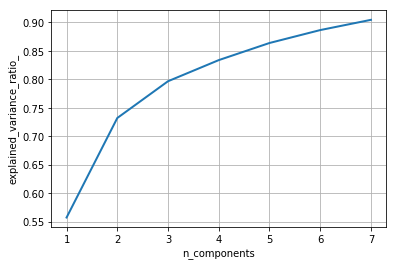

In [17]:
# Из огромного количества кодов и групп получили 12 компонент, которые объясняют >90 процентов дисперсии
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

# попробуем создать модель без MCC

In [18]:
comp = pd.DataFrame(data=components,columns= ['component 1','component 2','component 3','component 4','component 5',
                                                   'component 6','component 7'])  
comp.shape

(10217, 7)

# Делаем новый сводный датасет, без МСС, но с компонентами и channel_type для WOE

In [287]:
result_with_components = pd.concat([piv3,piv4,piv5,piv6,piv7,piv8,piv9,comp, piv11,piv12,piv13,piv14,piv15,piv16], axis=1)

# Удаляем id повторяющийся id клиента
result_with_components = result_with_components.drop(columns=['cl_id']).join(result_with_components['cl_id'].ix[:, 0:1])
# подцепляем chanel type
client_channel = train_test_mcc[['cl_id','channel_type']].groupby('cl_id').max().reset_index()
result_with_components = result_with_components.merge(client_channel, how = 'inner', left_on = 'cl_id', right_on = 'cl_id')
# Декодируем channel_type
le = LabelEncoder()
le.fit( result_with_components['channel_type'] )
result_with_components['channel_type'] = le.transform(result_with_components['channel_type'])

# Делим на трейн тест
general_train_with_components = result_with_components[result_with_components['IsTrain']==1].reset_index(drop= True)
general_test_with_components =  result_with_components[result_with_components['IsTrain']==0].reset_index(drop= True)
general_train_with_components.drop(columns=['IsTrain'], inplace=True)
general_test_with_components.drop(columns=['IsTrain'], inplace=True)

C:\Users\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [288]:
general_train_with_components_scaled, general_test_with_components_scaled = Scal(general_train_with_components,general_test_with_components)


In [250]:
general_train_with_components_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 38 columns):
BACK_TRX              5000 non-null float64
C2C_IN                5000 non-null float64
C2C_OUT               5000 non-null float64
CASH_ADV              5000 non-null float64
CAT                   5000 non-null float64
DEPOSIT               5000 non-null float64
POS                   5000 non-null float64
WD_ATM_OTHER          5000 non-null float64
WD_ATM_PARTNER        5000 non-null float64
WD_ATM_ROS            5000 non-null float64
DayDiff               5000 non-null float64
10_GR10               5000 non-null float64
1_GR10                5000 non-null float64
2_GR10                5000 non-null float64
3_GR10                5000 non-null float64
4_GR10                5000 non-null float64
5_GR10                5000 non-null float64
6_GR10                5000 non-null float64
7_GR10                5000 non-null float64
8_GR10                5000 non-null float64
9_GR10       

# пробуем теперь прогнать алгоритмы

In [289]:
CrosVal (logreg,kfold,general_train_with_components_scaled,y_train)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Значения правильности перекрестной проверки:
[0.81007448 0.80298792 0.80094999]


In [320]:
CrosVal (clf,kfold,general_train_with_components_scaled,y_train)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Значения правильности перекрестной проверки:
[0.84899114 0.83889539 0.85359599]


# Делаем бустинг на модели с компонентами

In [25]:
#Задаем параметры по умолчанию
params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}



In [291]:
data_train, data_test, target_train, target_test = train_test_split(general_train_with_components_scaled, y_train, test_size=0.4, random_state=42)
xgb = xgboost.XGBClassifier(**params)
xgb.fit(data_train, target_train)
y_train_predict = xgb.predict_proba(data_train)[:, 1]
y_test_predict = xgb.predict_proba(data_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(target_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(target_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:  0.92
Test:  0.86


# Подберем параметры для Boosting

In [27]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(data_train)),
                                                               np.arange(len(data_test)) + len(data_train))],
                  verbose=3)

    clf.fit(pd.concat([data_train, data_test]).values, pd.concat([target_train, target_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

#### Подбираем max_depth и min_child_weight

In [28]:
from sklearn.model_selection import GridSearchCV

clf_xgb = xgboost.XGBClassifier(**params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] max_depth=3, min_child_weight=10 ................................
[CV]  max_depth=3, min_child_weight=10, score=0.8334371481642556, total=   0.1s
[CV] max_depth=3, min_child_weight=20 ................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vec

[CV]  max_depth=3, min_child_weight=20, score=0.833913206059399, total=   0.1s
[CV] max_depth=3, min_child_weight=100 ...............................
[CV]  max_depth=3, min_child_weight=100, score=0.8238616271933212, total=   0.0s
[CV] max_depth=5, min_child_weight=10 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vec

[CV]  max_depth=5, min_child_weight=10, score=0.8400293052501514, total=   0.1s
[CV] max_depth=5, min_child_weight=20 ................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=5, min_child_weight=20, score=0.8387388174660917, total=   0.2s
[CV] max_depth=5, min_child_weight=100 ...............................
[CV]  max_depth=5, min_child_weight=100, score=0.8238616271933212, total=   0.1s
[CV] max_depth=10, min_child_weight=10 ...............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

[CV]  max_depth=10, min_child_weight=10, score=0.8374244505773663, total=   0.3s
[CV] max_depth=10, min_child_weight=20 ...............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  max_depth=10, min_child_weight=20, score=0.8396665460856558, total=   0.2s
[CV] max_depth=10, min_child_weight=100 ..............................
[CV]  max_depth=10, min_child_weight=100, score=0.8238616271933212, total=   0.1s


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s finished
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was 

Best test ROC AUC:  0.8400293052501514
Best params:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 10, 'missing': None, 'n_estimators': 50, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.8}


In [29]:
#### Подбираем subsample и colsample_bytree
clf_xgb = xgboost.XGBClassifier(**params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6)
}

params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] colsample_bytree=0.5, subsample=0.5 .............................
[CV]  colsample_bytree=0.5, subsample=0.5, score=0.8376215802073723, total=   0.1s
[CV] colsample_bytree=0.5, subsample=0.6 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vec

[CV]  colsample_bytree=0.5, subsample=0.6, score=0.8372766033548618, total=   0.1s
[CV] colsample_bytree=0.5, subsample=0.7 .............................
[CV]  colsample_bytree=0.5, subsample=0.7, score=0.8359673171267036, total=   0.1s
[CV] colsample_bytree=0.5, subsample=0.8 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vec

[CV]  colsample_bytree=0.5, subsample=0.8, score=0.8345391434412736, total=   0.1s
[CV] colsample_bytree=0.5, subsample=0.9 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.5, subsample=0.9, score=0.8370535623559632, total=   0.1s
[CV] colsample_bytree=0.5, subsample=1.0 .............................
[CV]  colsample_bytree=0.5, subsample=1.0, score=0.8346859745316647, total=   0.1s
[CV] colsample_bytree=0.6, subsample=0.5 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

[CV]  colsample_bytree=0.6, subsample=0.5, score=0.8385726798655454, total=   0.1s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV]  colsample_bytree=0.6, subsample=0.6, score=0.8392336738053334, total=   0.1s


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] colsample_bytree=0.6, subsample=0.7 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.6, subsample=0.7, score=0.838639744585032, total=   0.1s
[CV] colsample_bytree=0.6, subsample=0.8 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.6, subsample=0.8, score=0.8370555946201901, total=   0.1s
[CV] colsample_bytree=0.6, subsample=0.9 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.6, subsample=0.9, score=0.8374203860489124, total=   0.1s
[CV] colsample_bytree=0.6, subsample=1.0 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.6, subsample=1.0, score=0.8374701765224708, total=   0.1s
[CV] colsample_bytree=0.7, subsample=0.5 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.7, subsample=0.5, score=0.8395705216009365, total=   0.1s
[CV] colsample_bytree=0.7, subsample=0.6 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.7, subsample=0.6, score=0.8380488637610707, total=   0.1s
[CV] colsample_bytree=0.7, subsample=0.7 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.7, subsample=0.7, score=0.8398951758111783, total=   0.1s
[CV] colsample_bytree=0.7, subsample=0.8 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.7, subsample=0.8, score=0.837387361755226, total=   0.1s
[CV] colsample_bytree=0.7, subsample=0.9 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.7, subsample=0.9, score=0.8384680182578618, total=   0.1s
[CV] colsample_bytree=0.7, subsample=1.0 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.7, subsample=1.0, score=0.8374417248232946, total=   0.1s
[CV] colsample_bytree=0.8, subsample=0.5 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.8, subsample=0.5, score=0.8424314415663067, total=   0.1s
[CV] colsample_bytree=0.8, subsample=0.6 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.8, subsample=0.6, score=0.8410307034479395, total=   0.1s
[CV] colsample_bytree=0.8, subsample=0.7 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.8, subsample=0.7, score=0.8420371823062949, total=   0.1s
[CV] colsample_bytree=0.8, subsample=0.8 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.8, subsample=0.8, score=0.8400293052501514, total=   0.2s
[CV] colsample_bytree=0.8, subsample=0.9 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.8, subsample=0.9, score=0.8401964589828111, total=   0.1s
[CV] colsample_bytree=0.8, subsample=1.0 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.8, subsample=1.0, score=0.8368015615918319, total=   0.2s
[CV] colsample_bytree=0.9, subsample=0.5 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.9, subsample=0.5, score=0.8418466575350261, total=   0.1s
[CV] colsample_bytree=0.9, subsample=0.6 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.9, subsample=0.6, score=0.8404896130975366, total=   0.2s
[CV] colsample_bytree=0.9, subsample=0.7 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.9, subsample=0.7, score=0.8421128841487455, total=   0.2s
[CV] colsample_bytree=0.9, subsample=0.8 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.9, subsample=0.8, score=0.83865549463279, total=   0.2s
[CV] colsample_bytree=0.9, subsample=0.9 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.9, subsample=0.9, score=0.8399363291617723, total=   0.2s
[CV] colsample_bytree=0.9, subsample=1.0 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=0.9, subsample=1.0, score=0.8374813539757184, total=   0.2s
[CV] colsample_bytree=1.0, subsample=0.5 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=1.0, subsample=0.5, score=0.8419442062179157, total=   0.2s
[CV] colsample_bytree=1.0, subsample=0.6 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=1.0, subsample=0.6, score=0.839682296133414, total=   0.2s
[CV] colsample_bytree=1.0, subsample=0.7 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=1.0, subsample=0.7, score=0.8425427080327276, total=   0.2s
[CV] colsample_bytree=1.0, subsample=0.8 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=1.0, subsample=0.8, score=0.8386087525555723, total=   0.2s
[CV] colsample_bytree=1.0, subsample=0.9 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=1.0, subsample=0.9, score=0.8383867276887872, total=   0.2s
[CV] colsample_bytree=1.0, subsample=1.0 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  colsample_bytree=1.0, subsample=1.0, score=0.8384040019347156, total=   0.2s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    8.8s finished
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best test ROC AUC:  0.8425427080327276
Best params:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 10, 'missing': None, 'n_estimators': 50, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.7}


In [30]:
#### Подбираем регуляризацию: reg_lambda и reg_alpha
clf_xgb = xgboost.XGBClassifier(**params)

param_grid = {
    'reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}

params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] reg_alpha=0, reg_lambda=0 .......................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0, reg_lambda=0, score=0.8419706256528648, total=   0.2s
[CV] reg_alpha=0, reg_lambda=0.0001 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0, reg_lambda=0.0001, score=0.8419696095207514, total=   0.2s
[CV] reg_alpha=0, reg_lambda=0.001 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0, reg_lambda=0.001, score=0.8419675772565246, total=   0.2s
[CV] reg_alpha=0, reg_lambda=0.1 .....................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0, reg_lambda=0.1, score=0.842298328259447, total=   0.2s
[CV] reg_alpha=0, reg_lambda=1 .......................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0, reg_lambda=1, score=0.8425427080327276, total=   0.2s
[CV] reg_alpha=0.0001, reg_lambda=0 ..................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.0001, reg_lambda=0, score=0.8419696095207514, total=   0.2s
[CV] reg_alpha=0.0001, reg_lambda=0.0001 .............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.0001, reg_lambda=0.0001, score=0.8419696095207514, total=   0.2s
[CV] reg_alpha=0.0001, reg_lambda=0.001 ..............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.0001, reg_lambda=0.001, score=0.8419675772565245, total=   0.2s
[CV] reg_alpha=0.0001, reg_lambda=0.1 ................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.0001, reg_lambda=0.1, score=0.842298328259447, total=   0.2s
[CV] reg_alpha=0.0001, reg_lambda=1 ..................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.0001, reg_lambda=1, score=0.8425442322308977, total=   0.2s
[CV] reg_alpha=0.001, reg_lambda=0 ...................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.001, reg_lambda=0, score=0.8419675772565246, total=   0.2s
[CV] reg_alpha=0.001, reg_lambda=0.0001 ..............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.001, reg_lambda=0.0001, score=0.8419675772565245, total=   0.2s
[CV] reg_alpha=0.001, reg_lambda=0.001 ...............................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.001, reg_lambda=0.001, score=0.8419685933886379, total=   0.2s
[CV] reg_alpha=0.001, reg_lambda=0.1 .................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.001, reg_lambda=0.1, score=0.8422932475988798, total=   0.2s
[CV] reg_alpha=0.001, reg_lambda=1 ...................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.001, reg_lambda=1, score=0.8425421999666709, total=   0.2s
[CV] reg_alpha=0.1, reg_lambda=0 .....................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.1, reg_lambda=0, score=0.8425305144473665, total=   0.2s
[CV] reg_alpha=0.1, reg_lambda=0.0001 ................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.1, reg_lambda=0.0001, score=0.8425305144473665, total=   0.2s
[CV] reg_alpha=0.1, reg_lambda=0.001 .................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.1, reg_lambda=0.001, score=0.8425315305794798, total=   0.2s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.1, reg_lambda=0.1, score=0.8426463535082978, total=   0.2s
[CV] reg_alpha=0.1, reg_lambda=1 .....................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=0.1, reg_lambda=1, score=0.8422139892940321, total=   0.2s
[CV] reg_alpha=1, reg_lambda=0 .......................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=1, reg_lambda=0, score=0.8417292942759246, total=   0.2s
[CV] reg_alpha=1, reg_lambda=0.0001 ..................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=1, reg_lambda=0.0001, score=0.8417292942759246, total=   0.2s
[CV] reg_alpha=1, reg_lambda=0.001 ...................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=1, reg_lambda=0.001, score=0.8417282781438111, total=   0.2s
[CV] reg_alpha=1, reg_lambda=0.1 .....................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=1, reg_lambda=0.1, score=0.8419624965959573, total=   0.2s
[CV] reg_alpha=1, reg_lambda=1 .......................................


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV]  reg_alpha=1, reg_lambda=1, score=0.8418380204120619, total=   0.2s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    7.2s finished
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best test ROC AUC:  0.8426463535082978
Best params:  {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 10, 'missing': None, 'n_estimators': 50, 'n_jobs': 4, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.7}


In [37]:
#### Уменьшим learning_rate
params['learning_rate'] = 0.01
params['n_estimators'] = 500

clf_xgb = xgboost.XGBClassifier(**params)

clf_xgb.fit(data_train, target_train, eval_metric='auc', eval_set=[[data_train, target_train], [data_test, target_test]])

[0]	validation_0-auc:0.823461	validation_1-auc:0.806123
[1]	validation_0-auc:0.835572	validation_1-auc:0.818475
[2]	validation_0-auc:0.840313	validation_1-auc:0.822649
[3]	validation_0-auc:0.843002	validation_1-auc:0.826907
[4]	validation_0-auc:0.845187	validation_1-auc:0.828148
[5]	validation_0-auc:0.846796	validation_1-auc:0.829333
[6]	validation_0-auc:0.847929	validation_1-auc:0.829292
[7]	validation_0-auc:0.847453	validation_1-auc:0.829823
[8]	validation_0-auc:0.848878	validation_1-auc:0.830544
[9]	validation_0-auc:0.848776	validation_1-auc:0.830186
[10]	validation_0-auc:0.850306	validation_1-auc:0.831429
[11]	validation_0-auc:0.85067	validation_1-auc:0.831472
[12]	validation_0-auc:0.851051	validation_1-auc:0.832091
[13]	validation_0-auc:0.851975	validation_1-auc:0.832449
[14]	validation_0-auc:0.852597	validation_1-auc:0.833467
[15]	validation_0-auc:0.852719	validation_1-auc:0.833964
[16]	validation_0-auc:0.852646	validation_1-auc:0.834072
[17]	validation_0-auc:0.853409	validation_

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[19]	validation_0-auc:0.853658	validation_1-auc:0.834152
[20]	validation_0-auc:0.853347	validation_1-auc:0.83396
[21]	validation_0-auc:0.854369	validation_1-auc:0.834222
[22]	validation_0-auc:0.854402	validation_1-auc:0.834223
[23]	validation_0-auc:0.854764	validation_1-auc:0.834305
[24]	validation_0-auc:0.855111	validation_1-auc:0.834656
[25]	validation_0-auc:0.855308	validation_1-auc:0.834783
[26]	validation_0-auc:0.855288	validation_1-auc:0.834927
[27]	validation_0-auc:0.855482	validation_1-auc:0.835647
[28]	validation_0-auc:0.856067	validation_1-auc:0.835698
[29]	validation_0-auc:0.856122	validation_1-auc:0.836003
[30]	validation_0-auc:0.856456	validation_1-auc:0.836077
[31]	validation_0-auc:0.856896	validation_1-auc:0.836488
[32]	validation_0-auc:0.857078	validation_1-auc:0.836509
[33]	validation_0-auc:0.857086	validation_1-auc:0.836352
[34]	validation_0-auc:0.857201	validation_1-auc:0.836458
[35]	validation_0-auc:0.857403	validation_1-auc:0.836462
[36]	validation_0-auc:0.857716	v

[163]	validation_0-auc:0.877619	validation_1-auc:0.841642
[164]	validation_0-auc:0.877777	validation_1-auc:0.841739
[165]	validation_0-auc:0.877883	validation_1-auc:0.841843
[166]	validation_0-auc:0.877956	validation_1-auc:0.841863
[167]	validation_0-auc:0.878046	validation_1-auc:0.84185
[168]	validation_0-auc:0.878152	validation_1-auc:0.841919
[169]	validation_0-auc:0.878245	validation_1-auc:0.841937
[170]	validation_0-auc:0.878427	validation_1-auc:0.841868
[171]	validation_0-auc:0.878555	validation_1-auc:0.841926
[172]	validation_0-auc:0.87867	validation_1-auc:0.841868
[173]	validation_0-auc:0.878789	validation_1-auc:0.841907
[174]	validation_0-auc:0.878846	validation_1-auc:0.841983
[175]	validation_0-auc:0.878984	validation_1-auc:0.841941
[176]	validation_0-auc:0.879128	validation_1-auc:0.841983
[177]	validation_0-auc:0.879347	validation_1-auc:0.842036
[178]	validation_0-auc:0.879508	validation_1-auc:0.842017
[179]	validation_0-auc:0.879691	validation_1-auc:0.842171
[180]	validation

[305]	validation_0-auc:0.894852	validation_1-auc:0.844127
[306]	validation_0-auc:0.894924	validation_1-auc:0.844114
[307]	validation_0-auc:0.894973	validation_1-auc:0.84411
[308]	validation_0-auc:0.895051	validation_1-auc:0.844128
[309]	validation_0-auc:0.895065	validation_1-auc:0.844096
[310]	validation_0-auc:0.895124	validation_1-auc:0.844101
[311]	validation_0-auc:0.89518	validation_1-auc:0.84413
[312]	validation_0-auc:0.895304	validation_1-auc:0.844138
[313]	validation_0-auc:0.895418	validation_1-auc:0.844107
[314]	validation_0-auc:0.89549	validation_1-auc:0.844105
[315]	validation_0-auc:0.895617	validation_1-auc:0.844072
[316]	validation_0-auc:0.895719	validation_1-auc:0.844062
[317]	validation_0-auc:0.895803	validation_1-auc:0.844062
[318]	validation_0-auc:0.895967	validation_1-auc:0.844009
[319]	validation_0-auc:0.896063	validation_1-auc:0.843968
[320]	validation_0-auc:0.896154	validation_1-auc:0.843992
[321]	validation_0-auc:0.896373	validation_1-auc:0.844029
[322]	validation_0

[447]	validation_0-auc:0.908265	validation_1-auc:0.843993
[448]	validation_0-auc:0.90843	validation_1-auc:0.844002
[449]	validation_0-auc:0.908583	validation_1-auc:0.844025
[450]	validation_0-auc:0.908656	validation_1-auc:0.844027
[451]	validation_0-auc:0.908746	validation_1-auc:0.844007
[452]	validation_0-auc:0.908802	validation_1-auc:0.843969
[453]	validation_0-auc:0.908996	validation_1-auc:0.843993
[454]	validation_0-auc:0.909063	validation_1-auc:0.843978
[455]	validation_0-auc:0.90921	validation_1-auc:0.844027
[456]	validation_0-auc:0.909294	validation_1-auc:0.843996
[457]	validation_0-auc:0.909442	validation_1-auc:0.843986
[458]	validation_0-auc:0.909546	validation_1-auc:0.844003
[459]	validation_0-auc:0.9098	validation_1-auc:0.844019
[460]	validation_0-auc:0.90986	validation_1-auc:0.84397
[461]	validation_0-auc:0.909971	validation_1-auc:0.843983
[462]	validation_0-auc:0.910015	validation_1-auc:0.843988
[463]	validation_0-auc:0.910079	validation_1-auc:0.844001
[464]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=10, missing=None, n_estimators=500,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

# посмотрим как распределяются значения количества операций в последние дни полльзования для двух параметров таргета

C:\Users\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


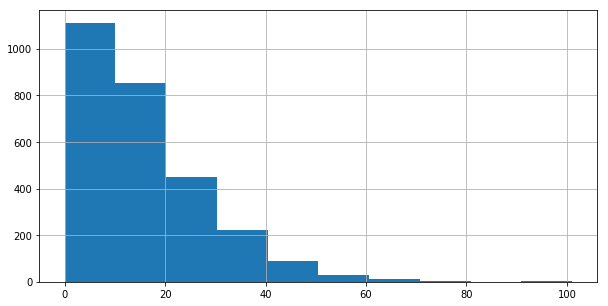

In [38]:
##x=general_train_with_components['Target'] = y_train
x=general_train_with_components[general_train_with_components['Target']==1]
x['koef'] = x['2_GR2'] / x['1_GR2']
x['10_GR10'].hist(figsize=(10,5))

C:\Users\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


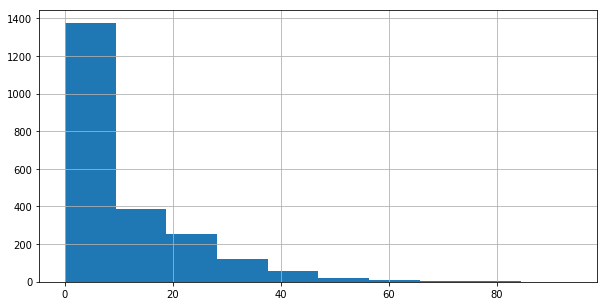

In [39]:
##y=general_train_with_components['Target'] = y_train
y = general_train_with_components[general_train_with_components['Target']==0]
y['koef'] = y['2_GR2'] / y['1_GR2']
y['10_GR10'].hist(figsize=(10,5))

In [43]:
import scipy.stats as st
?st.ttest_1samp (sample,df['weight'].mean())

In [45]:
st.stats.ttest_ind(x['10_GR10'],y['10_GR10'], equal_var=False)


Ttest_indResult(statistic=14.516471387759939, pvalue=9.093457812835807e-47)

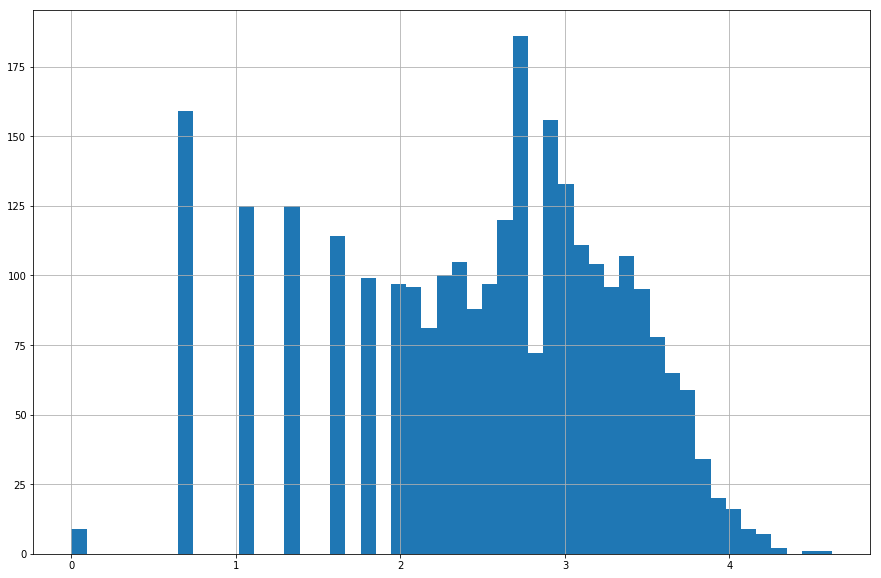

In [54]:
log_x = np.log1p(x['10_GR10'])
log_x.hist(figsize = (15,10), bins=50)

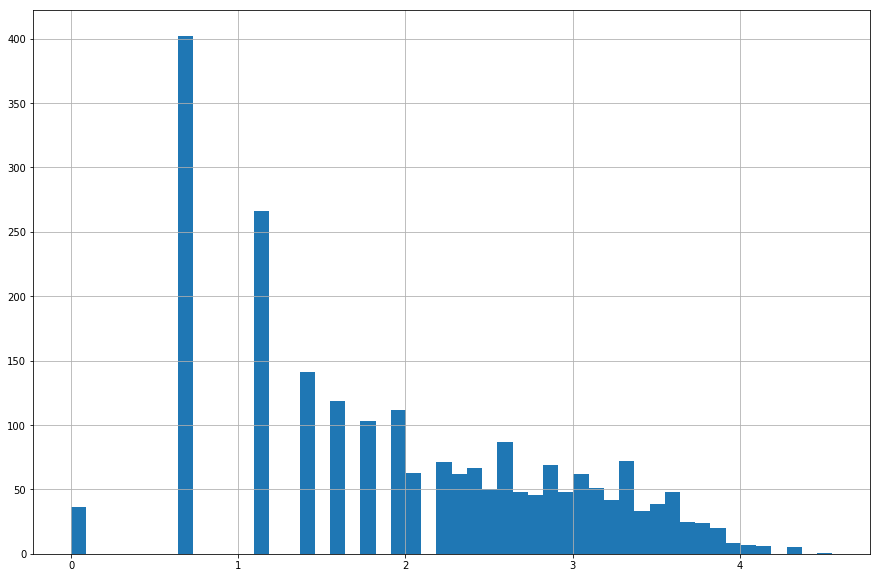

In [52]:
log_y = np.log1p(y['10_GR10'])
log_y.hist(figsize = (15,10), bins=50)

In [91]:
st.stats.ttest_ind(x['10_GR10'],y['10_GR10'], equal_var=False)


Ttest_indResult(statistic=14.516471387759939, pvalue=9.093457812835807e-47)

# Посмотрим матрицу корреляций

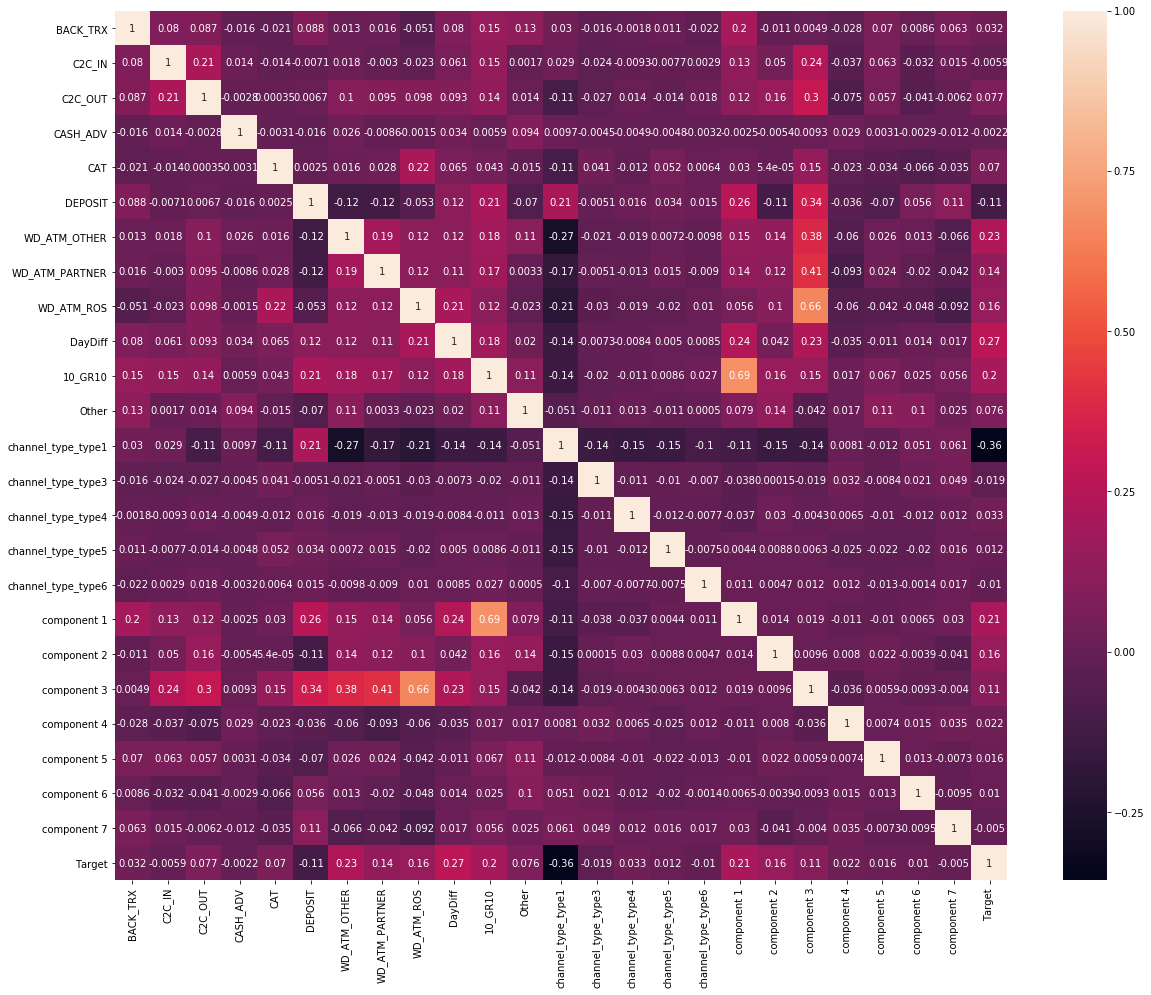

In [62]:
from matplotlib import pyplot
pyplot.figure(figsize=(20, 16))


corr = general_train_with_components.drop(columns=['POS', '1_GR10', '2_GR10', '3_GR10', '4_GR10', '5_GR10', '6_GR10', '7_GR10',
       '8_GR10', '9_GR10', '1_GR2', '2_GR2','RUB','channel_type_type2']).corr()
sns.heatmap(corr, annot=True, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [84]:
general_train_with_components_wo_corr = general_train_with_components.drop(columns=['POS', '1_GR10', '2_GR10', '3_GR10', '4_GR10', '5_GR10', '6_GR10', '7_GR10',
       '8_GR10', '9_GR10', '1_GR2', '2_GR2','RUB','channel_type_type2'])
general_test_with_components_wo_corr = general_test_with_components.drop(columns=['POS', '1_GR10', '2_GR10', '3_GR10', '4_GR10', '5_GR10', '6_GR10', '7_GR10',
       '8_GR10', '9_GR10', '1_GR2', '2_GR2','RUB','channel_type_type2'])

In [85]:
general_train_with_components_wo_corr_scaled, general_test_with_components_wo_corr_scaled = Scal(general_train_with_components_wo_corr,general_test_with_components_wo_corr)


In [86]:
CrosVal (logreg,kfold,general_train_with_components_wo_corr_scaled,y_train)

Значения правильности перекрестной проверки:
[0.79431215 0.78725316 0.79254575]


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [92]:
CrosVal (clf,kfold,general_train_with_components_wo_corr_scaled,y_train)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Значения правильности перекрестной проверки:
[0.83630699 0.82173536 0.83767193]


In [137]:
data_train, data_test, target_train, target_test = train_test_split(general_train_with_components_wo_corr_scaled, y_train, test_size=0.4, random_state=42)
xgb = xgboost.XGBClassifier(**params)
xgb.fit(data_train, target_train)
y_train_predict = xgb.predict_proba(data_train)[:, 1]
y_test_predict = xgb.predict_proba(data_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(target_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(target_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:  0.9
Test:  0.84


# попробуем сделать предсказание для тестовых данных, без корреляционных переменных

In [136]:
xgb = xgboost.XGBClassifier(**params)
xgb.fit(general_train_with_components_wo_corr_scaled, y_train)
y_test_predict = xgb.predict(general_test_with_components_wo_corr_scaled)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [96]:
predict = pd.DataFrame(test_cl_id)
predict['pr'] = y_test_predict
predict.to_csv ('predict.csv', index= False)

# Попробуем WOE

In [219]:
# пробуем функцию из урока

def get_woe_stat(df_train, col, target_col):
    df_train['target'] = target_col
    stat = df_train.groupby(col)['target'].agg(
        [np.mean, np.size, np.count_nonzero], sort=False
    )
    stat.rename(columns={'count_nonzero': 'good', 'size': 'obs', 'mean': 'event_rate'}, inplace=True)
    stat['all_good'] = stat['good'].sum()
    stat['p_good'] = stat['good'] / stat['all_good']
    stat['p_good'] = stat['p_good'].replace(0, 0.000001)
    stat['bad'] = stat['obs'] - stat['good']
    stat['all_bad'] = stat['bad'].sum()
    stat['p_bad'] = stat['bad'] / stat['all_bad']
    stat['p_bad'] = stat['p_bad'].replace(0, 0.000001)
    stat['WOE']=np.log(stat['p_good'] / stat['p_bad'])
   
    stat['variable'] = col
    stat['category'] = stat.index
    stat.reset_index(inplace=True)
    stat.drop(labels=col, inplace=True, axis=1)
    IV = ((stat['p_good'] - stat['p_bad']) * stat['WOE']).sum()
    return IV

In [305]:
def get_woe_v1(df_train, df_test, col, target_col):
    df_train['target'] = target_col
    all_good = len(df_train[df_train['target'] == 1][col])
    all_bad = len(df_train[df_train['target'] == 0][col])
    odds_series = (
        df_train[df_train['target'] == 1][col].value_counts()
        /
        df_train[df_train['target'] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    df_train.drop(columns = ['target'], inplace = True)
    return df_train, df_test 

In [294]:
##Получили список важных фичей
woe_dict = {}
for col in general_train_with_components:
    
    val = get_woe_stat(general_train_with_components,col,y_train)
    woe_dict[col] = val
sorted(woe_dict.items(), key=lambda x: x[1])

[('channel_type_type6', 0.0004394716562349373),
 ('channel_type_type5', 0.0005439916869368621),
 ('channel_type_type3', 0.0014224239900683146),
 ('channel_type_type4', 0.004850208032505762),
 ('CASH_ADV', 0.008704036210735032),
 ('BACK_TRX', 0.04219103235043174),
 ('C2C_IN', 0.06698064999567221),
 ('CAT', 0.10966300034499847),
 ('C2C_OUT', 0.11916781200426922),
 ('DEPOSIT', 0.18041151653908707),
 ('1_GR10', 0.19422654831626),
 ('Other', 0.22567711788754233),
 ('WD_ATM_PARTNER', 0.22768226910215783),
 ('2_GR10', 0.30862207215797904),
 ('3_GR10', 0.3157165111619788),
 ('4_GR10', 0.37291506348101905),
 ('WD_ATM_ROS', 0.4032689661568363),
 ('5_GR10', 0.4053549974004073),
 ('7_GR10', 0.41462732890916826),
 ('6_GR10', 0.4366301714503225),
 ('8_GR10', 0.4367411853892537),
 ('10_GR10', 0.4771635620612494),
 ('9_GR10', 0.502276170022879),
 ('channel_type_type1', 0.5752517410794182),
 ('channel_type_type2', 0.6180489097839805),
 ('channel_type', 0.6388053571266008),
 ('1_GR2', 0.6716247821022758

In [310]:
# Сделаем WOE для channel type. получим набор c woe колонкой. Затем отшкалируем его
general_train_with_components_with_WOE, general_test_with_components_with_WOE = get_woe_v1(general_train_with_components, general_test_with_components,'channel_type',y_train)
general_train_with_components_with_WOE.drop(columns=['channel_type'], inplace= True)
general_test_with_components_with_WOE.drop(columns=['channel_type'], inplace= True)

general_train_with_components_with_WOE_scalled, general_test_with_components_with_WOE_scalled = Scal(general_train_with_components_with_WOE, general_test_with_components_with_WOE)


# посмотрим на CV для данных с woe.

In [376]:
CrosVal (logreg,kfold,general_train_with_components_with_WOE_scalled,y_train)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Значения правильности перекрестной проверки:
[0.81008894 0.80297023 0.80095291]


C:\Users\Python\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [314]:
CrosVal (clf,kfold,general_train_with_components_with_WOE_scalled,y_train)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Значения правильности перекрестной проверки:
[0.84809369 0.83675674 0.85541147]


In [315]:
data_train, data_test, target_train, target_test = train_test_split(general_train_with_components_with_WOE_scalled, y_train, test_size=0.4, random_state=42)
xgb = xgboost.XGBClassifier(**params)
xgb.fit(data_train, target_train)
y_train_predict = xgb.predict_proba(data_train)[:, 1]
y_test_predict = xgb.predict_proba(data_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(target_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(target_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train:  0.92
Test:  0.86


# точность чуть улучшилась. Результат не столь заметен, так как в переменной не так много значений.

# попробуем еще раз загрузить на сайт

In [436]:
xgb = xgboost.XGBClassifier(**params)
xgb.fit(general_train_with_components_with_WOE_scalled, y_train)
y_test_predict = xgb.predict_proba(general_test_with_components_with_WOE_scalled)

C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [440]:
predict = pd.DataFrame(test_cl_id)
predict['_VAL_'] = y_test_predict[:, 1]
predict.to_csv ('predict.csv', index= False)

In [319]:
##Получилось 0.7628

# Попробуем SVM

In [368]:
clf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=20, max_features=0.8, n_jobs=-1)
clf.fit(general_train_with_components_with_WOE,y_train)
y_test_predict = clf.predict_proba(general_test_with_components_with_WOE)

predict = pd.DataFrame(test_cl_id)
predict['_VAL_'] = y_test_predict[:, 1]


predict.to_csv ('predict.csv', index= False)

C:\Users\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
